## 1: Setup of the environment

pyton module installation if necessary

In [1]:
# !pip install pandas
# !pip install numpy
# !pip install scipy
# !pip install matplotlib
# !pip install openpyxl
# !pip install seaborn
# !pip install statannotations

all imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
from scipy.ndimage import gaussian_filter
from scipy import stats
from statannotations.Annotator import Annotator

sns.set_theme()
sns.set_style("white")
sns.set_palette("muted")

Data reading and preparation

In [3]:
def timeToSec(x):
    m,s = x.split(':')
    return int(s) + (int(m)*60)
def loopOverSeries(x):
    return x.apply(lambda i: checkCoordinates(i))
def checkCoordinates(x):
    if type(x) == type(' '):
        return list(map(int,x.split(' ')))
    elif type(x) == type([]):
        return x
    return []
def saverow(row):
    idx = row.name
    temp_df['Task type'][idx*2] = 'direct'
    temp_df['Task type'][idx*2 + 1] = 'indirect'
    temp_df['Participant ID'][idx*2] = row[xlsx_columns[1]]
    temp_df['Participant ID'][idx*2 + 1] = row[xlsx_columns[1]]
    temp_df['Mental Demand'][idx*2] = row[xlsx_columns[4]]
    temp_df['Mental Demand'][idx*2 + 1] = row[xlsx_columns[12]]
    temp_df['Physical Demand'][idx*2] = row[xlsx_columns[5]]
    temp_df['Physical Demand'][idx*2 + 1] = row[xlsx_columns[13]]
    temp_df['Performance'][idx*2] = row[xlsx_columns[6]]
    temp_df['Performance'][idx*2 + 1] = row[xlsx_columns[14]]
    temp_df['Effort'][idx*2] = row[xlsx_columns[7]]
    temp_df['Effort'][idx*2 + 1] = row[xlsx_columns[15]]
    temp_df['Frustration Level'][idx*2] = row[xlsx_columns[8]]
    temp_df['Frustration Level'][idx*2 + 1] = row[xlsx_columns[16]]
    temp_df['Restrictivity'][idx*2] = row[xlsx_columns[10]]
    temp_df['Restrictivity'][idx*2 + 1] = row[xlsx_columns[18]]
    temp_df['Complexity'][idx*2] = row[xlsx_columns[11]]
    temp_df['Complexity'][idx*2 + 1] = row[xlsx_columns[19]]
    temp_df['TLX'][idx*2] = row[xlsx_columns[9]]
    temp_df['TLX'][idx*2 + 1] = row[xlsx_columns[17]]

#list of variables to test
variables = ['Task completion time','Total number of taps','Number of erroneous inputs','TLX','Mental Demand','Physical Demand','Performance','Effort','Frustration Level','Restrictivity','Complexity']
xlsx_columns = ['Zeitstempel','Participant ID','First','Second','Keyframe Mental Demand','Keyframe Physical Demand','Keyframe Performance','Keyframe Effort','Keyframe Frustration Level','Keyframe TLX score','Keyframe Restrictivity','Keyframe Complexity','Pin Mental Demand','Pin Physical Demand','Pin Performance','Pin Effort','Pin Frustration Level','Pin Raw TLX','Pin Restrictivity','Pin Complexity','Preference','Keyframe Experience','Pin Experience','Suggestions']

#Read data from csv(touch data) and xlsx(question answers) file
data = pd.read_csv('study_results.csv')
temp_data = pd.read_excel("Study Results.xlsx")

#convert task completion times in data from str to int (represented in secounds)
data['Task completion time'] = data['Task completion time'].apply(lambda x: timeToSec(x))

#fix empty coordinate representation in data
list_of_columns = ['Tap x coord.','Tap y coord.','Error x coord.','Error y coord.']
data[list_of_columns] = data[list_of_columns].apply(lambda x: (loopOverSeries(x)))

temp_df = {
    'Task type':[0 for i in range(16)],
    'Participant ID':[0 for i in range(16)],
    'Mental Demand':[0 for i in range(16)],
    'Physical Demand':[0 for i in range(16)],
    'Performance':[0 for i in range(16)],
    'Effort':[0 for i in range(16)],
    'Frustration Level':[0 for i in range(16)],
    'Restrictivity':[0 for i in range(16)],
    'Complexity':[0 for i in range(16)],
    'TLX':[0 for i in range(16)]
}

temp_data.apply(saverow,axis=1)
temp_df = pd.DataFrame(temp_df)
data = pd.merge(data, temp_df, on=['Task type','Participant ID'],how="left")

## 2: Heatmaps

Read all the touch and erroneous touch coordinates from data

In [4]:

# [ [list of x coord.] , [list of y coord.] ]
direct_tap = [[],[]]
direct_tap[0] = [x for sublist in data.loc[data['Task type'] == 'direct', 'Tap x coord.'] for x in sublist]
direct_tap[1] = [y for sublist in data.loc[data['Task type'] == 'direct', 'Tap y coord.'] for y in sublist]
indirect_tap = [[],[]]
indirect_tap[0] = [x for sublist in data.loc[data['Task type'] == 'indirect', 'Tap x coord.'] for x in sublist]
indirect_tap[1] = [y for sublist in data.loc[data['Task type'] == 'indirect', 'Tap y coord.'] for y in sublist]
direct_err = [[],[]]
direct_err[0] = [x for sublist in data.loc[data['Task type'] == 'direct', 'Error x coord.'] for x in sublist]
direct_err[1] = [y for sublist in data.loc[data['Task type'] == 'direct', 'Error y coord.'] for y in sublist]
indirect_err = [[],[]]
indirect_err[0] = [x for sublist in data.loc[data['Task type'] == 'indirect', 'Error x coord.'] for x in sublist]
indirect_err[1] = [y for sublist in data.loc[data['Task type'] == 'indirect', 'Error y coord.'] for y in sublist]

Plot the headmaps from the read data

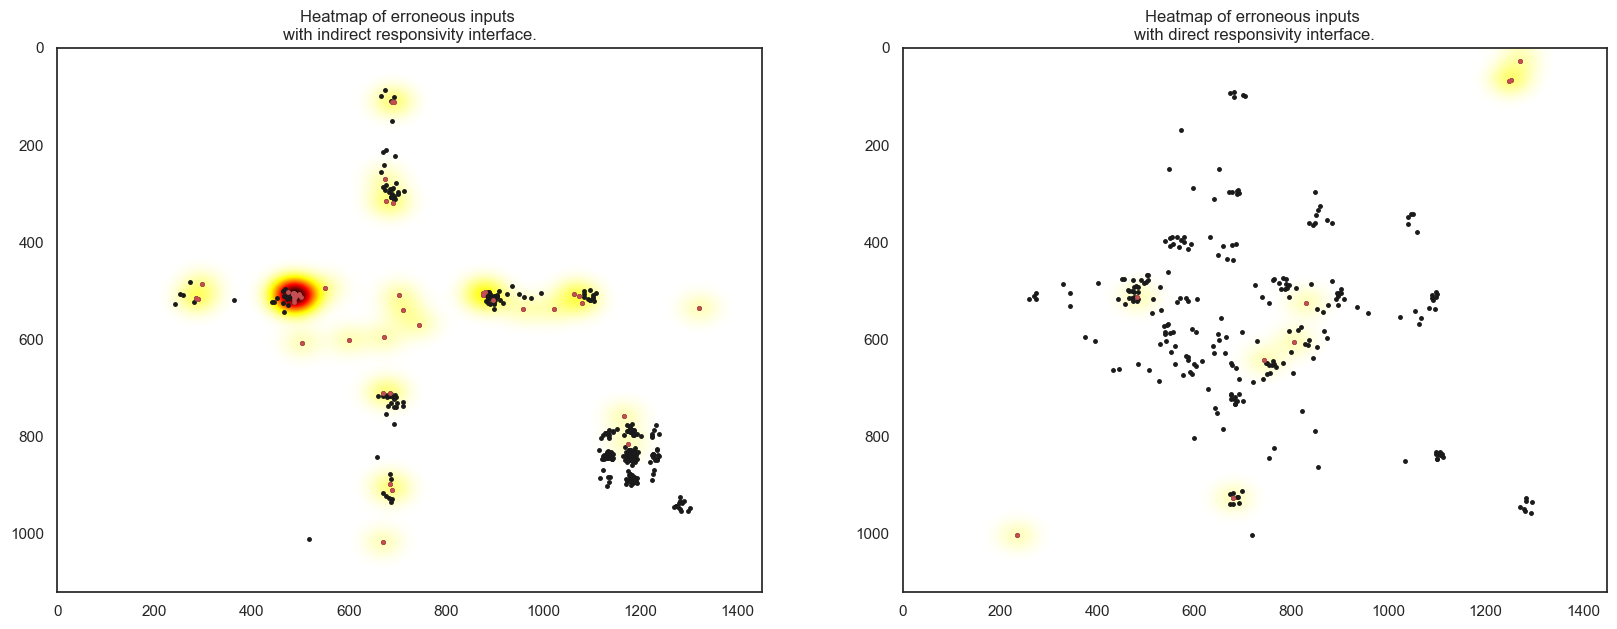

In [5]:
def heatmap(err, sigma, bins = 1000):
    heatmap, xedges, yedges = np.histogram2d(err[0], err[1], bins=bins, range=[[0,1450],[0,1120]])
    heatmap = gaussian_filter(heatmap, sigma=sigma)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

plt.figure(figsize=(20,40))
s = 20

hMap1, extent1 = heatmap(indirect_err, s)
hMap2, extent2 = heatmap(direct_err, s)
vmin = min(hMap1.min(), hMap2.min())
vmax = max(hMap1.max(), hMap2.max())

#Heatmap of indirect variant
plt.subplot(221)
plt.plot(indirect_tap[0], indirect_tap[1], 'k.', markersize=5)
plt.plot(indirect_err[0], indirect_err[1], 'r.', markersize=5)
plt.imshow(hMap1, extent=extent1, origin='lower', cmap=cm.hot_r, vmin=vmin, vmax=vmax)
plt.title("Heatmap of erroneous inputs \nwith indirect responsivity interface.")
plt.gca().invert_yaxis()

#Heatmap of direct variant
plt.subplot(222)
plt.plot(direct_tap[0], direct_tap[1], 'k.', markersize=5)
plt.plot(direct_err[0], direct_err[1], 'r.', markersize=5)
plt.imshow(hMap2, extent=extent2, origin='lower', cmap=cm.hot_r, vmin=vmin, vmax=vmax)
plt.title("Heatmap of erroneous inputs \nwith direct responsivity interface.")
plt.gca().invert_yaxis()

# plt.savefig("heatmaps.pdf")
plt.show()

## 3: Properties of the data

### Plotting data

Statistics on task completion time
              mean        std        sem    y_error
Task type                                          
direct     159.375  37.720542  13.336226  26.139002
indirect   147.875  28.341980  10.020403  19.639990
----------------------------------------------------------------------------------------------------
Statistics on total number of taps
             mean        std       sem    y_error
Task type                                        
direct     32.375   8.879149  3.139253   6.152936
indirect   46.500  16.044581  5.672616  11.118327
----------------------------------------------------------------------------------------------------
Statistics on number of erroneous inputs
            mean       std       sem  y_error
Task type                                    
direct     1.125  0.991031  0.350382  0.68675
indirect   6.000  4.898979  1.732051  3.39482
-----------------------------------------------------------------------------------------------

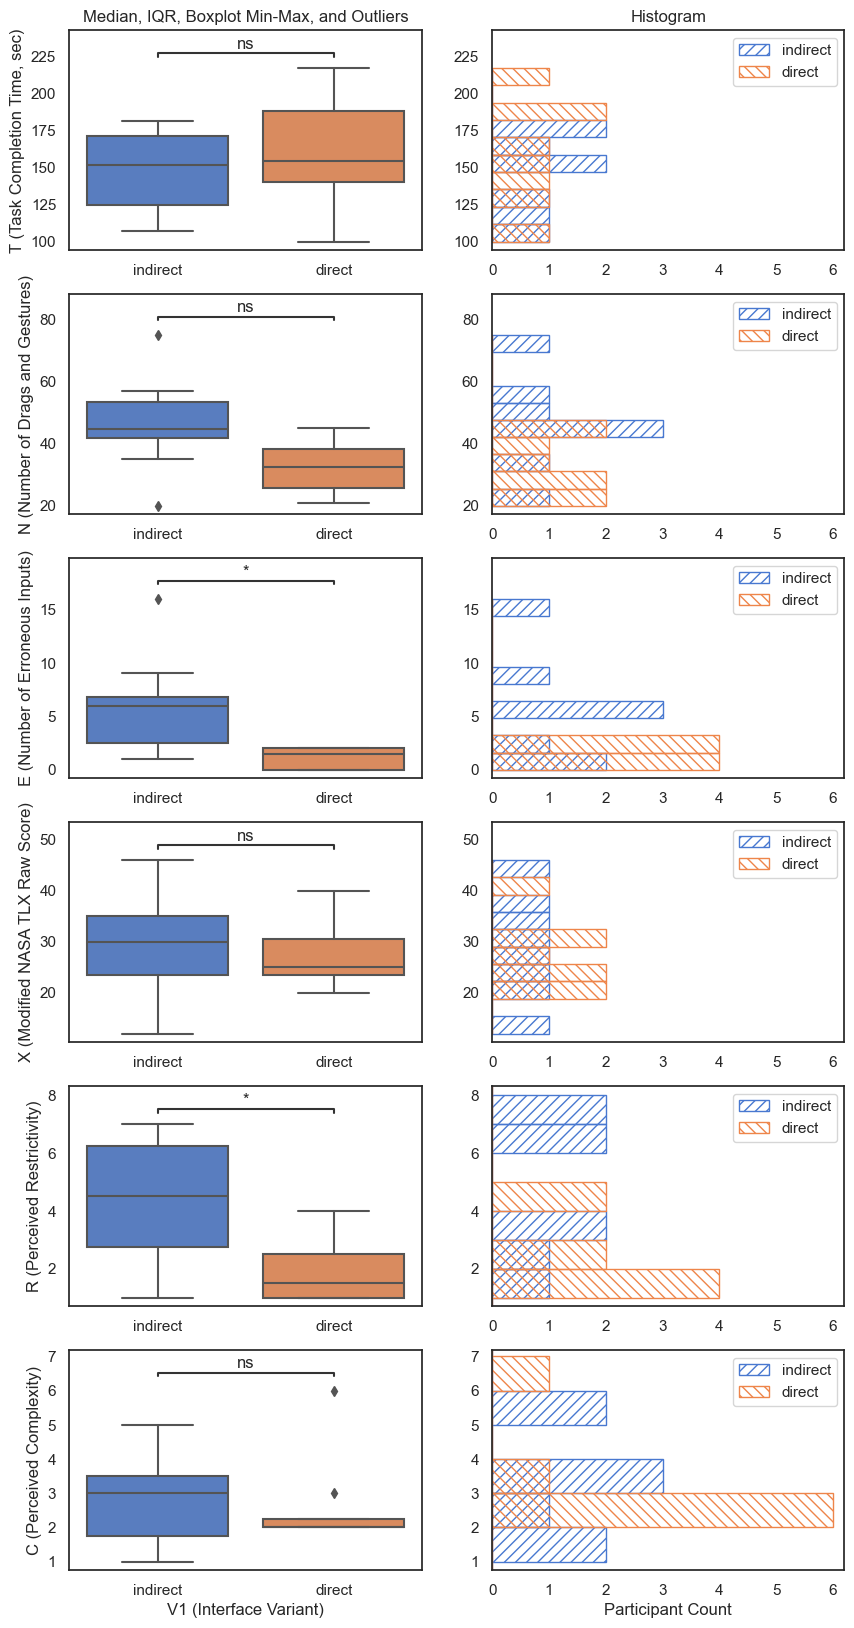

In [6]:
indices = [0,1,2,3,9,10]
variables = [variables[i] for i in indices]

fig, axs = plt.subplots(len(variables),2)
width = 10
height = 20
fig.set_size_inches(width,height)
names = ["T (Task Completion Time, sec)", "N (Number of Drags and Gestures)", "E (Number of Erroneous Inputs)", "X (Modified NASA TLX Raw Score)", "R (Perceived Restrictivity)", "C (Perceived Complexity)"]
for i in range(len(variables)):
    hist_min = data[variables[i]].min()
    hist_max = data[variables[i]].max()
    if i>3:
        hist_min = 0
        hist_max = 10
    variable_stats = data.groupby(['Task type'])[variables[i]].agg(['mean', 'std', 'sem'])
    variable_stats['y_error'] = variable_stats['sem'] * 1.96
    print("Statistics on "+ variables[i].lower())
    print(variable_stats)
    print('-'*100)

    sns.boxplot(data=data, x='Task type', y=variables[i], ax=axs[i,0])
    sigannot = Annotator(axs[i,0], [("indirect", "direct")], data=data, x='Task type', y=variables[i], order=["indirect", "direct"])
    sigannot.configure(test=None, text_format='star', loc='inside', verbose=False)
    sigannot.set_pvalues([(0.04 if i in [2, 4] else 1)])
    sigannot.annotate()
    axs[i,0].set_xlabel(None)
    axs[i,0].set_ylabel(names[i])

    axs[i,1].hist(data.loc[data['Task type'] == 'indirect', variables[i]], label='indirect',range=(hist_min,hist_max), hatch="///", facecolor="none", edgecolor=sns.color_palette("muted")[0], orientation='horizontal')
    axs[i,1].hist(data.loc[data['Task type'] == 'direct', variables[i]], label='direct',range=(hist_min,hist_max), hatch="\\\\\\", facecolor="none", edgecolor=sns.color_palette("muted")[1], orientation='horizontal')
    axs[i,1].set_xlim(0,6.2)
    axs[i,1].set_ylim(axs[i,0].get_ylim())
    axs[i,1].legend()

    if i == 0:
      axs[i,0].set_title("Median, IQR, Boxplot Min-Max, and Outliers")
      axs[i,1].set_title("Histogram")
    elif i == len(variables) - 1:
      axs[i,0].set_xlabel("V1 (Interface Variant)")
      axs[i,1].set_xlabel("Participant Count")

#display plot
# plt.savefig("graphs.pdf", facecolor="#F5F5F5", bbox_inches="tight", pad_inches=0.2)
plt.show()

### Levene's and Shapiro-Wilk test on touch input data and raw TLX 

In [7]:
a = 0.05 #significance level
shapiro_tests = []
levene_tests = []
final_tests = []
for x in variables[:4]:
    shapiro_tests.append(stats.shapiro(data[x]))
    levene_tests.append(stats.levene(data.loc[data['Task type'] == 'direct', x],data.loc[data['Task type'] == 'indirect', x]))
for i, x in enumerate(variables[:4]):
    print(x+':\n\tShapiro-Wilk p-value: '+str(shapiro_tests[i].pvalue)+'\tLevene p-value: '+str(levene_tests[i].pvalue)+'\n\t', end="")

    if shapiro_tests[i].pvalue<0.05 or levene_tests[i].pvalue<0.05:
        print("======> For the variable ["+variables[i]+"] run Wilcoxon signed rank test...\n\t\t Wilcoxon p-value: ", end='')
        final_tests.append(stats.wilcoxon(data.loc[data['Task type'] == 'direct', x], data.loc[data['Task type'] == 'indirect', x]))
    else:
        print("======> For the variable ["+variables[i]+"] run Paired t-test...\n\t\t Paired T-test p-value: ", end='')
        final_tests.append(stats.ttest_rel(data.loc[data['Task type'] == 'direct', x], data.loc[data['Task type'] == 'indirect', x]))
    print(final_tests[i].pvalue)
    
    result = ""
    if final_tests[i].pvalue > a:
        result = "WE FAILED TO REJECT THE NULL HYPOTHESIS ON THE "+x.upper()
    else:
        result = "WE CAN CONFIDENTLY REJECT THE NULL HYPOTHESIS ON THE "+x.upper()
    print("    |"+(len(result)+6)*'-'+"|")
    print("    |   "+result+"   |")
    print("    |"+(len(result)+6)*"-"+"|")


Task completion time:
	Shapiro-Wilk p-value: 0.963104248046875	Levene p-value: 0.5079023847327878
	======> For the variable [Task completion time] run Paired t-test...
		 Paired T-test p-value: 0.5396844354367989
    |-------------------------------------------------------------------------|
    |   WE FAILED TO REJECT THE NULL HYPOTHESIS ON THE TASK COMPLETION TIME   |
    |-------------------------------------------------------------------------|
Total number of taps:
	Shapiro-Wilk p-value: 0.34086811542510986	Levene p-value: 0.4436412706413655
	======> For the variable [Total number of taps] run Paired t-test...
		 Paired T-test p-value: 0.07357029159660457
    |-------------------------------------------------------------------------|
    |   WE FAILED TO REJECT THE NULL HYPOTHESIS ON THE TOTAL NUMBER OF TAPS   |
    |-------------------------------------------------------------------------|
Number of erroneous inputs:
	Shapiro-Wilk p-value: 0.0012692235177382827	Levene p-value: 0.

### Wilcoxon test on questionaire answers

In [8]:
a=0.05
for i, x in enumerate(variables[-2:]):

    print("======> For the variable ["+x+"] run Wilcoxon signed rank test...\n\t\t Wilcoxon p-value: ", end='')
    final_tests.append(stats.wilcoxon(data.loc[data['Task type'] == 'direct', x], data.loc[data['Task type'] == 'indirect', x]))
    print(final_tests[4+i].pvalue)
    
    result = ""
    if final_tests[4+i].pvalue > a:
        result = "WE FAILED TO REJECT THE NULL HYPOTHESIS ON THE "+x.upper()
    else:
        result = "WE CAN CONFIDENTLY REJECT THE NULL HYPOTHESIS ON THE "+x.upper()
    print("    |"+(len(result)+6)*'-'+"|")
    print("    |   "+result+"   |")
    print("    |"+(len(result)+6)*"-"+"|")


======> For the variable [Restrictivity] run Wilcoxon signed rank test...
		 Wilcoxon p-value: 0.033966233087128726
    |------------------------------------------------------------------------|
    |   WE CAN CONFIDENTLY REJECT THE NULL HYPOTHESIS ON THE RESTRICTIVITY   |
    |------------------------------------------------------------------------|
======> For the variable [Complexity] run Wilcoxon signed rank test...
		 Wilcoxon p-value: 0.7316005889599013
    |---------------------------------------------------------------|
    |   WE FAILED TO REJECT THE NULL HYPOTHESIS ON THE COMPLEXITY   |
    |---------------------------------------------------------------|


/Users/alexanderzank/.pyenv/versions/3.10.8/lib/python3.10/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/alexanderzank/.pyenv/versions/3.10.8/lib/python3.10/site-packages/scipy/stats/_morestats.py:3351: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
